# Using Machine Learning to Forecast Air Quality in Beijing

## 2 - Exploratory Data Analysis

### Import Python Packages

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load cleaned data set

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_daily.csv',
                 index_col=0,
                 parse_dates=[0],
                 date_parser=pd.to_datetime,
                 infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2010-01-02 to 2015-12-31
Data columns (total 17 columns):
No                 2190 non-null float64
year               2190 non-null float64
month              2190 non-null float64
day                2190 non-null float64
hour               2190 non-null float64
season             2190 non-null float64
PM_Dongsi          1079 non-null float64
PM_Dongsihuan      1032 non-null float64
PM_Nongzhanguan    1079 non-null float64
pm25               2190 non-null float64
dew_point          2190 non-null float64
humidity           2190 non-null float64
pressure           2190 non-null float64
temp               2190 non-null float64
wind_speed         2190 non-null float64
precipitation      2190 non-null float64
Iprec              2190 non-null float64
dtypes: float64(17)
memory usage: 308.0 KB


In [0]:
df.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,pm25,dew_point,humidity,pressure,temp,wind_speed,precipitation,Iprec
2010-01-02,36.5,2010.0,1.0,2.0,11.5,4.0,NaN,NaN,NaN,144.333333,-8.500000,77.937500,1024.750000,-5.125000,24.860000,0.000000,0.000000
2010-01-03,60.5,2010.0,1.0,3.0,11.5,4.0,NaN,NaN,NaN,78.375000,-10.125000,87.916667,1022.791667,-8.541667,70.937917,0.466667,5.508333
2010-01-04,84.5,2010.0,1.0,4.0,11.5,4.0,NaN,NaN,NaN,29.291667,-20.875000,46.208333,1029.291667,-11.500000,111.160833,0.000000,0.000000
2010-01-05,108.5,2010.0,1.0,5.0,11.5,4.0,NaN,NaN,NaN,43.541667,-24.583333,42.041667,1033.625000,-14.458333,56.920000,0.000000,0.000000
2010-01-06,132.5,2010.0,1.0,6.0,11.5,4.0,NaN,NaN,NaN,59.375000,-23.708333,39.208333,1033.750000,-12.541667,18.511667,0.000000,0.000000


### Visualize daily PM2.5 over entire time span

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Air Quality, 2010-2015')

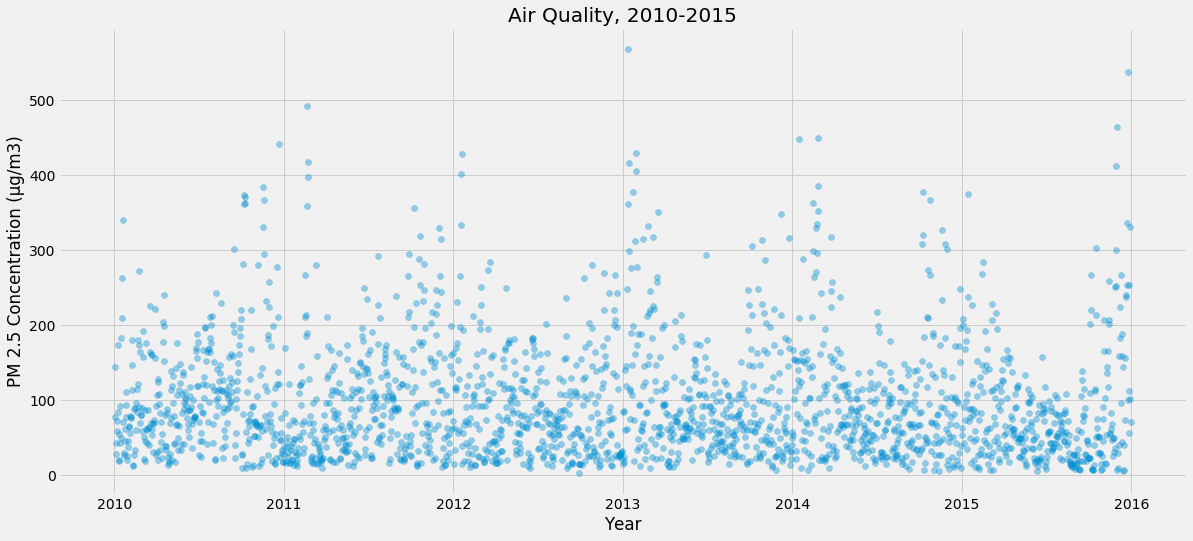

In [0]:
# Generate a simple scatter plot of daily mean PM2.5 concentration for entire time span
scatter_y = df.pm25.resample('D').mean()
scatter_x = df.pm25.resample('D').mean().index
#color = scatter_y

plt.scatter(x = scatter_x, y = scatter_y, alpha = 0.4)
plt.xlabel('Year')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality, 2010-2015')

### Visualize distribution of PM2.5

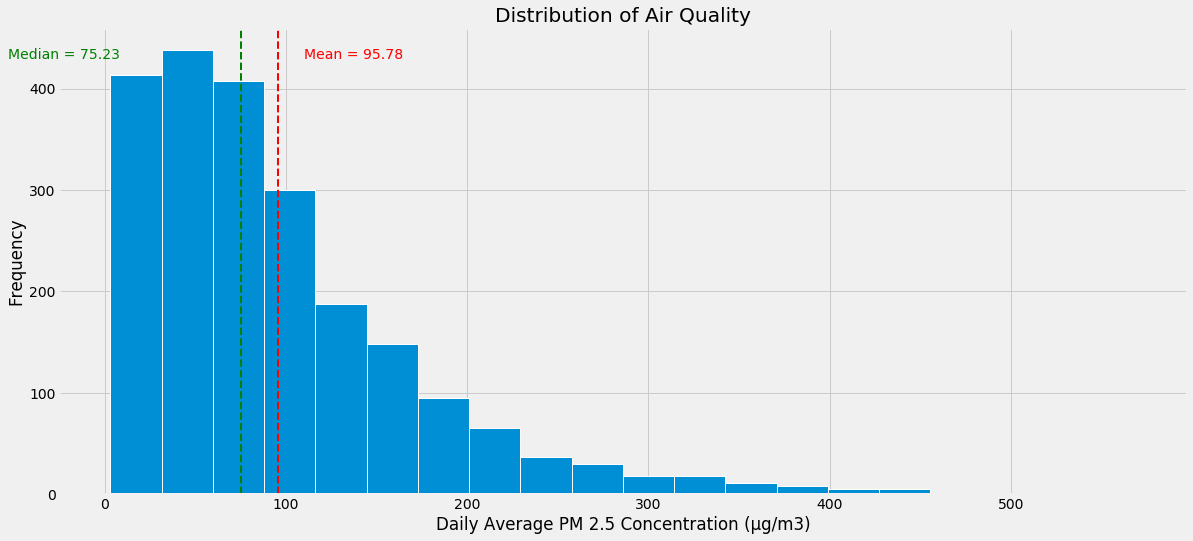

In [0]:
# Distribution of air quality for the period 2010-2015
plt.figure()
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)

### Visualize proportion of days characterized by each PM2.5 classification

Text(0.5, 1.0, 'Percentage of Days Within Each Air Quality Classification')

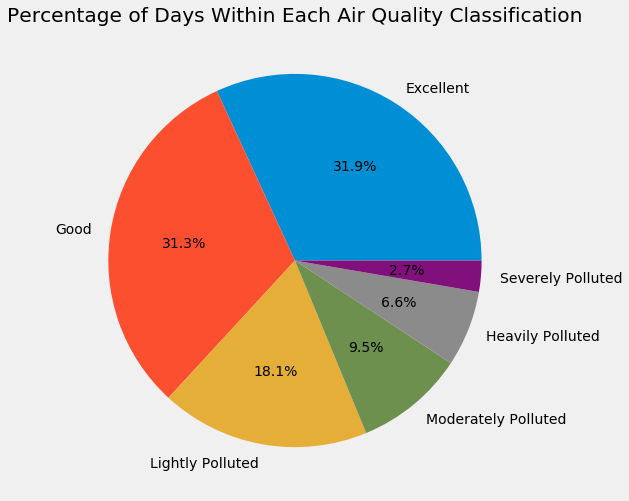

In [0]:
# Generate a pie chart to show portion of days falling into each air quality classification
excellent = len([ii for ii in scatter_y.dropna() if ii <= 50])
good = len([ii for ii in scatter_y.dropna() if ii > 50 and ii <= 100])
lightly = len([ii for ii in scatter_y.dropna() if ii > 100 and ii <= 150])
moderately = len([ii for ii in scatter_y.dropna() if ii > 150 and ii <= 200])
heavily = len([ii for ii in scatter_y.dropna() if ii > 200 and ii <= 300])
severely = len([ii for ii in scatter_y.dropna() if ii > 300])
sizes = [excellent, good, lightly, moderately, heavily, severely]
labels = ['Excellent','Good','Lightly Polluted','Moderately Polluted','Heavily Polluted','Severely Polluted']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Days Within Each Air Quality Classification')

### Visualize PM2.5 by month

([<matplotlib.axis.XTick at 0x7f481213e828>,
 <a list of 12 Text xticklabel objects>)

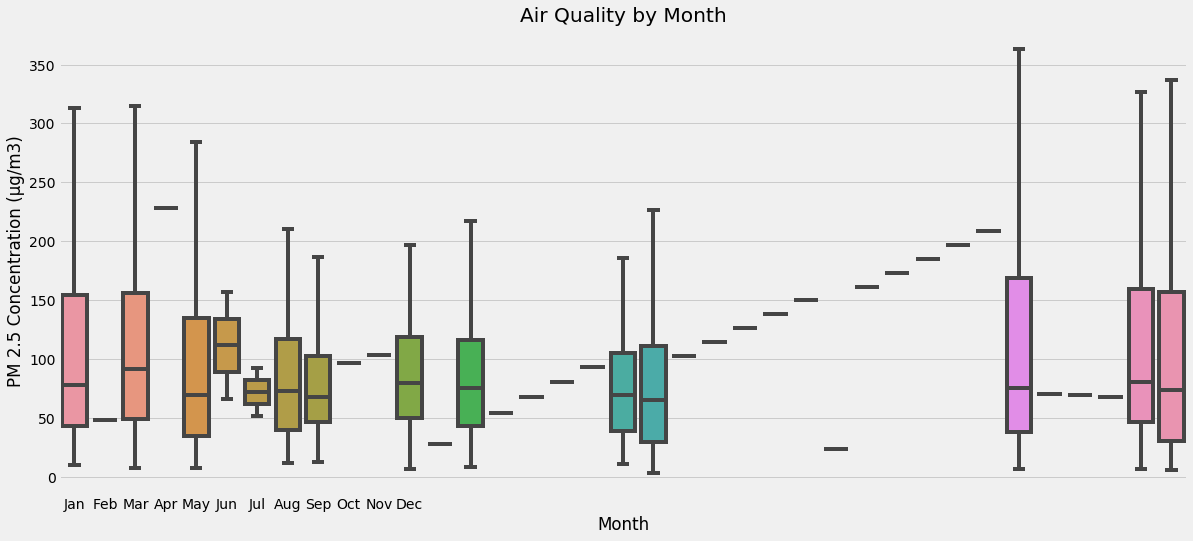

In [0]:
# Plot PM 2.5 level by MONTH
plt.figure()
sns.boxplot(x="month", y="pm25", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])

### Visualize PM2.5 by day of the week

In [0]:
# Plot PM 2.5 level by DAY OF THE WEEK
df_length = df.shape[0]

weekday = []

for ii in list(range(df_length)):
    weekday.append(calendar.weekday(df.year[ii],
        df.month[ii], df.day[ii]))
    
df['weekday'] = weekday

plt.figure()
sns.boxplot(x="weekday", y="pm25", data=df, showfliers=False)
plt.xlabel('Day of the Week')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day of the Week')
plt.xticks(range(0,7), calendar.day_name)

TypeError: ignored

### Visualize PM2.5 by hour of the day

Text(0.5, 1.0, 'Air Quality by Hour of the Day')

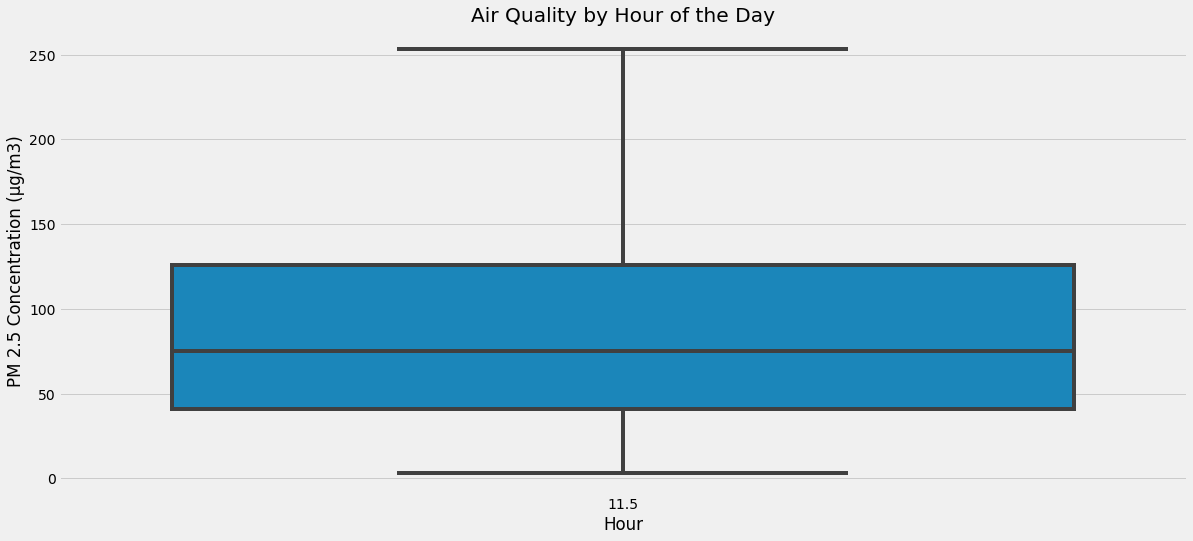

In [0]:
# Plot PM 2.5 level by HOUR OF THE DAY

plt.figure()
sns.boxplot(x="hour", y="pm25", data=df, showfliers=False)
plt.xlabel('Hour')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Hour of the Day')

### Perform univariate analysis for all weather features 

Text(0.5, 1.0, 'Air Quality vs. Temperature')

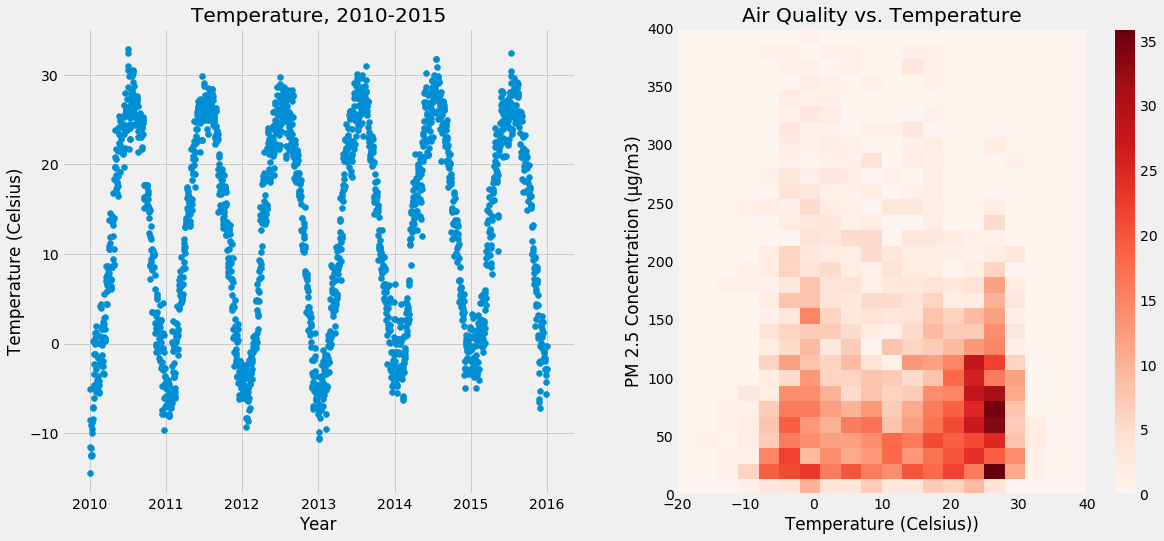

In [0]:
# Now we take a look at the other features apart from air concentration:

# Temperature

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.temp.resample('D').mean().index, y = df.temp.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.temp, y = df.pm25, bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Temperature (Celsius))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Temperature')

Text(0.5, 1.0, 'Air Quality vs. Pressure')

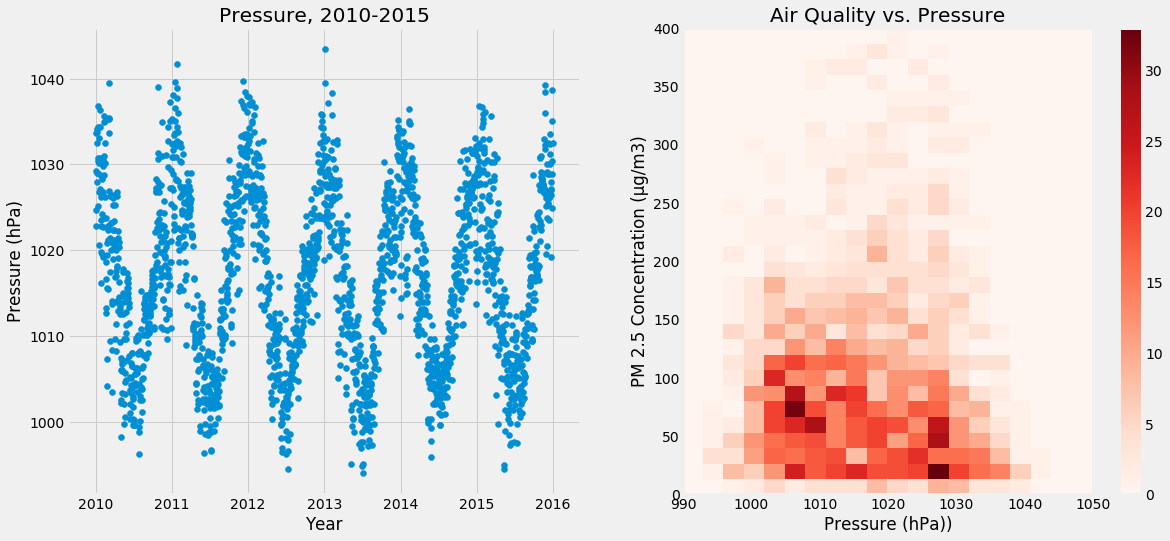

In [0]:
# Pressure

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.pressure.resample('D').mean().index, y = df.pressure.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.title('Pressure, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.pressure, y = df.pm25, bins = (20, 30), range = ((990,1050),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Pressure (hPa))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Pressure')

Text(0.5, 1.0, 'Air Quality vs. Humidity')

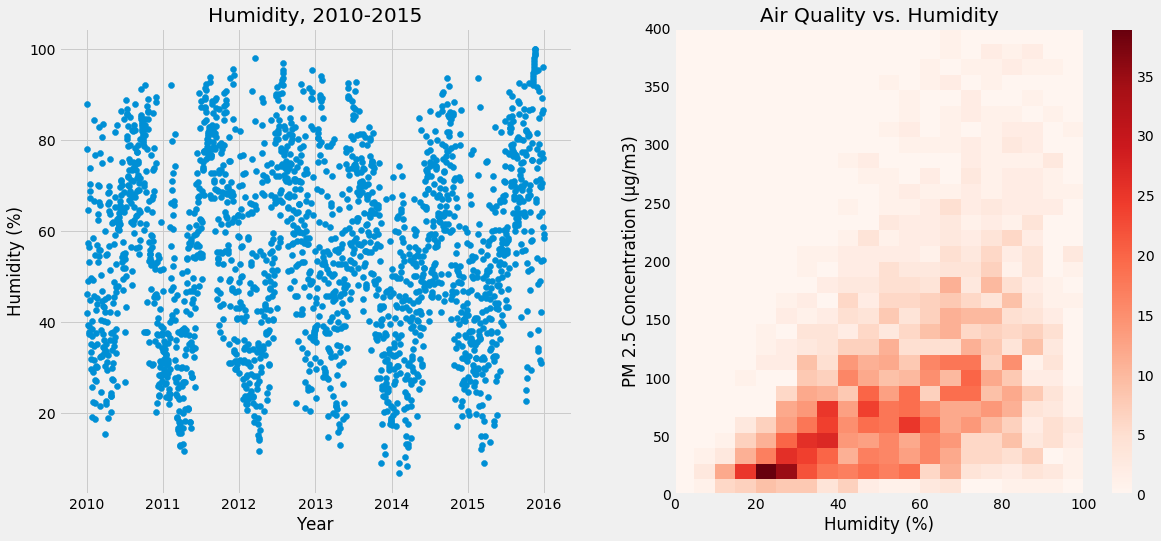

In [0]:
# Humidity

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.humidity.resample('D').mean().index, y = df.humidity.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Humidity (%)')
plt.title('Humidity, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.humidity, y = df.pm25, bins = (20, 30), range = ((0,100),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Humidity (%)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Humidity')

Text(0.5, 1.0, 'Air Quality vs. Dew Point')

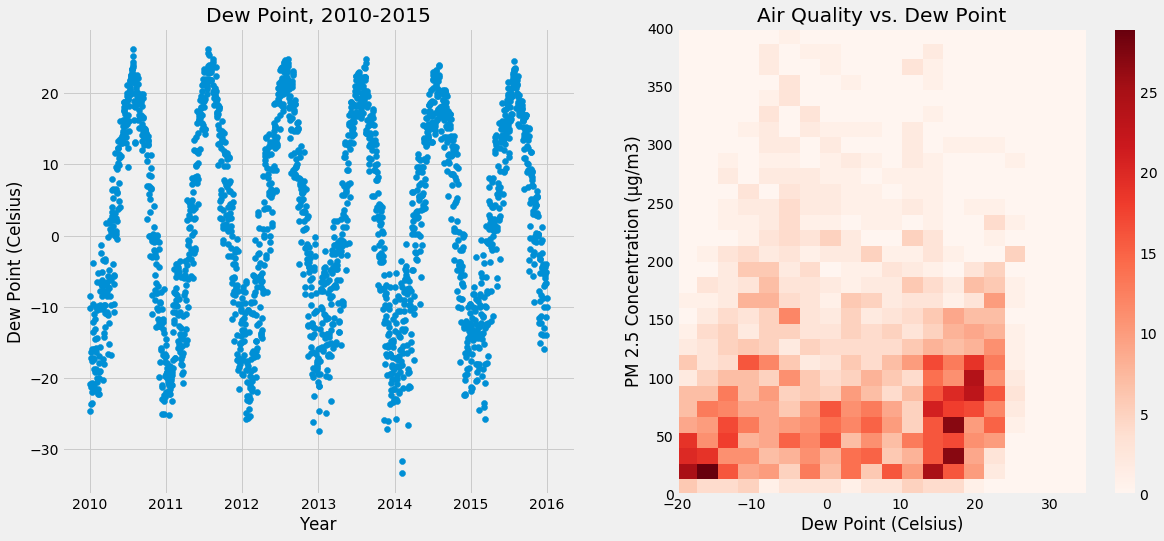

In [0]:
# Dew Point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.dew_point.resample('D').mean().index, y = df.dew_point.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Dew Point (Celsius)')
plt.title('Dew Point, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.dew_point, y = df.pm25, bins = (20, 30), range = ((-20,35),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Dew Point (Celsius)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Dew Point')

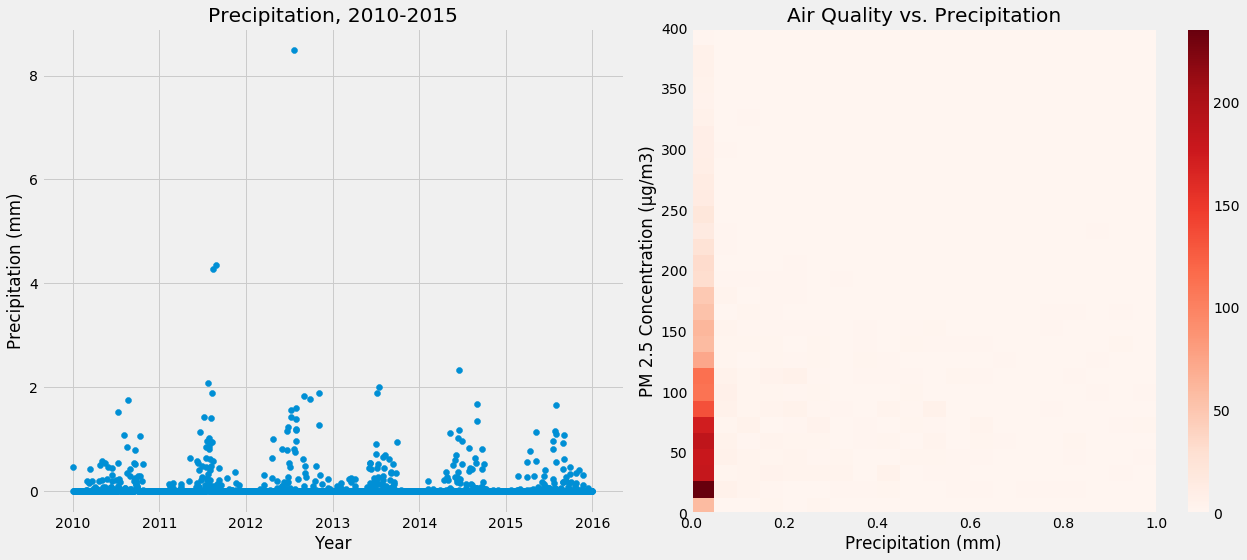

In [0]:
# Precipitation

df.precipitation[df.precipitation >= 1000] = np.nan  # Remove erroneous 999990.0 point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.precipitation.resample('D').mean().index, y = df.precipitation.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.precipitation, y = df.pm25,
           bins = (20, 30), range = ((0,1),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Precipitation (mm)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Precipitation')
plt.tight_layout()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2010-01-02 to 2015-12-31
Data columns (total 17 columns):
No                 2190 non-null float64
year               2190 non-null float64
month              2190 non-null float64
day                2190 non-null float64
hour               2190 non-null float64
season             2190 non-null float64
PM_Dongsi          1079 non-null float64
PM_Dongsihuan      1032 non-null float64
PM_Nongzhanguan    1079 non-null float64
pm25               2190 non-null float64
dew_point          2190 non-null float64
humidity           2190 non-null float64
pressure           2190 non-null float64
temp               2190 non-null float64
wind_speed         2190 non-null float64
precipitation      2189 non-null float64
Iprec              2190 non-null float64
dtypes: float64(17)
memory usage: 388.0 KB


In [0]:
df.to_csv("df_readyforml.csv")